In [1]:
!pip install nmrglue
!pip install peakutils
!pip install scikit-ued
from sys import path_hooks
import pathlib as pth
import numpy as np
import nmrglue as ng
from matplotlib import pyplot as plt
import pandas as pd
from peakutils import baseline
import os
import skued

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.7 MB/s eta 0:00:00
  Created wheel for pycifrw: filename=PyCifRW-4.4.6-cp310-cp310-linux_x86_64.whl size=160875 sha256=a04b46ab6f45ad3e842b4ef3566efa46eafb720d0428c233a28799df2e507fa9
  Stored in directory: /root/.cache/pip/wheels/2b/6e/4e/808875fdfc5b8

In [7]:
class SpectraSequence:
    def __init__(self, file_path, sequence, order = False, apply_mask=True):
        self.file_path = file_path
        self.df = pd.read_csv(os.path.join(self.file_path, 'dict.csv'))
        self.sequence = list(sequence)
        self.data = []
        self.dict_info = {
            'peak_widths': [], 'centers' : [], 'borders': [], 'multiplet_types': [],
            'overlaps': [], 'acquisition_time': [], 'order': []
            }
        self.phases = []
        self.spectras = []
        self.freqs = []
        self.areas = []
        self.id = {
            '1': [], 'y': [], 'x': []
            }
        if not isinstance(self.file_path, str):
            raise TypeError(f"Ожидался тип str для file_path, получено {type(self.file_path)}")
        if not isinstance(self.sequence, list):
            raise TypeError(f"Ожидался тип list для sequence, получено {type(self.sequence)}")
        self.read_files()
        self.size = [len(self.sequence), len(self.data[0]), [len(self.data[i][0]) for i in range(len(self.data))]]
        self.proper_phases()
        self.perform_fourier()
        self.spectras, self.freqs = self.apply_mask(apply_mask)
        self.noize_spectra_idx()
        self.identify()
        self.fix_overlaps()
        if order:
            self.dict_info['order'] = self.distribute_idx_by_order(order)

    def read_files(self):
        for seq in self.sequence:
            tmp = os.path.join(self.file_path, seq)
            d, da = ng.varian.read(tmp)
            self.data.append(da)
            filtered_df = self.df[self.df['nucleus'] == seq]
            if filtered_df.empty:
                raise ValueError(f"Не удалось найти информацию для {seq} в файле dict.csv")
            self.dict_info['peak_widths'].append(filtered_df['peak_width'].values[0])
            self.dict_info['centers'].append(filtered_df['center'].values[0])
            self.dict_info['borders'].append(filtered_df['borders'].values[0])
            self.dict_info['multiplet_types'].append(filtered_df['multiplet_type'].values[0])
            self.dict_info['overlaps'].append(int(filtered_df['overlaps'].values[0]))
            self.dict_info['acquisition_time'].append(float(d['procpar']['at']['values'][0]))

    def proper_phases(self):
        for i in range(self.size[0]):
            spectrum_unpr = np.fft.fft(self.data[i][0])
            spectrum, phase = ng.proc_autophase.autops(spectrum_unpr, 'acme', return_phases=True)
            self.phases.append(phase)


    def noize_spectra_idx(self) -> list:
        thresholds = [np.mean([max(np.real(spec)) for spec in spectra]) / 2 for spectra in self.spectras]
        noise_indices = [
            [idx for idx, max_val in enumerate([max(np.real(spec)) for spec in spectra]) if max_val < thresholds[i]]
            for i, spectra in enumerate(self.spectras)
        ]
        return noise_indices


    def identify(self):
        tmp = self.noize_spectra_idx()
        for i in range(self.size[0]):
            n_i = tmp[i]
            i_i = []
            r_i = []
            for j in range(self.size[1]-1):
                spec = self.spectras[i][j+1]
                spec_re = ((np.real(spec) / max(abs(np.real(spec))))*3)
                spec_im = ((np.imag(spec) / max(abs(np.imag(spec))))*3)
                if j+1 not in n_i and np.std(spec_re) > np.std(spec_im):
                    i_i.append(j+1)
                elif j+1 not in n_i and np.std(spec_re) < np.std(spec_im):
                    r_i.append(j+1)
            self.id['1'].append(n_i)
            self.id['y'].append(i_i)
            self.id['x'].append(r_i)

    def check_indices_consistency(self):
        """Проверяем, что для каждого ядра количество элементов в '1', 'x' и 'y' одинаково"""
        for i, seq in enumerate(self.sequence):
            len_im_idx = len(self.id['y'][i])
            len_re_idx = len(self.id['x'][i])
            len_noize_idx = len(self.id['1'][i])
            if len_im_idx != len_re_idx or len_im_idx != len_noize_idx and order:
                self.id['x'][i] = self.dict_info['acquisition_time'][i][0]
                self.id['y'][i] = self.dict_info['acquisition_time'][i][1]
                self.id['1'][i] = self.dict_info['acquisition_time'][i][2]
            else:
                raise ValueError(f"Несоответствие количества элементов в 'y', 'x' и '1', восстановите порядок импульсов order для продолжения")


    def perform_fourier(self, apply_mask = True):
        for i in range(self.size[0]):
            freq = np.fft.fftfreq(len(self.data[i][0]), self.dict_info['acquisition_time'][i] / len(self.data[i][0]))
            self.freqs.append(freq)
            spec_set = []
            for j in range(self.size[1]):
                spectrum = np.fft.fft(self.data[i][j]) * np.exp(1j * 2 * np.pi / 360 * (self.phases[i][0]))
                spec_set.append(spectrum)
            self.spectras.append(spec_set)


    def prepare_spectras(self, k) -> list:
        p_s = []
        for i in range(self.size[0]):
            t = []
            for j in range(self.size[1]):
                if j in self.id['y'][i]:
                    corr = (-np.imag(self.spectras[i][j]) / max(-np.imag(self.spectras[i][j])) * k)**5
                    t.append(corr / max(corr))
                elif j in self.id['x'][i]:
                    corr = (np.real(self.spectras[i][j]) / max(np.real(self.spectras[i][j])) * k)**5
                    t.append(corr/max(corr))
                else:
                    t.append(self.spectras[i][j] / max(self.spectras[i][j]))
            p_s.append(t)
        return p_s

    def locate_peaks(self, k) -> list:
        p_s = self.prepare_spectras(k)
        peaks = []
        for i in range(self.size[0]):
            peaks_set = []
            for j in range(self.size[1]):
                peaks_subset = []
                if j not in self.id['1'][i] and j != 0:
                    loc_peaks = ng.analysis.peakpick.pick(p_s[i][j], 0.05, -0.2)
                    for k in range(len(loc_peaks)):
                        peaks_subset.append(int(loc_peaks[k][0]))
                else: peaks_subset.append(None)
                peaks_set.append(peaks_subset)
            peaks.append(peaks_set)
        return peaks


    def correct_baselines(self, iter):
        for i in range(self.size[0]):
            for j in self.id['x'][i]:
                bl = skued.baseline_dwt(self.spectras[i][j], iter)
                self.spectras[i][j] -= bl


    def apply_mask(self, apply_mask) -> tuple:
        spectras = []
        frequencies = []
        for freq, spectrum_set, center, region in zip(self.freqs, self.spectras, self.dict_info['centers'], self.dict_info['borders']):
            if apply_mask:
                mask = (freq >= center - region) & (freq <= center + region)
                frequencies.append(freq[mask])
                spectras.append([spectrum[mask] for spectrum in spectrum_set])
            else:
                frequencies.append(freq)
                spectras.append(spectrum_set)
        return spectras, frequencies

    def calculate_areas(self, peaks) -> list:
        for i, freq_set in enumerate(self.freqs):
            areas = []
            dnu = freq_set[1] - freq_set[0]
            width = int(self.dict_info['peak_widths'][i] / dnu)
            fig, axs = plt.subplots(7, 4, figsize=(20, 35))
            axs = axs.flatten()

            for j, spectrum in enumerate(self.spectras[i]):
                N = self.get_peak_count(self.dict_info['multiplet_types'][i])
                re_areas_ss = [0.0] * N
                im_areas_ss = [0.0] * N
                axs[j].plot(freq_set, np.real(spectrum), label='Re')
                # axs[j].plot(freq_set, np.imag(spectrum), label='Im')

                for peak_index, peak in enumerate(peaks[i][j]):
                    if peak is not None:
                        left = max(peak - width, 0)
                        right = min(peak + width, len(freq_set) - 1)
                        axs[j].fill_between(
                            freq_set[left:right], np.real(spectrum[left:right]), alpha=0.3, color='blue'
                        )
                        re_areas_ss[peak_index] += np.trapz(np.real(spectrum[left:right]), freq_set[left:right])
                        # axs[j].fill_between(
                        #     freq_set[left:right], np.imag(spectrum[left:right]), alpha=0.3, color='red'
                        # )
                        im_areas_ss[peak_index] += np.trapz(np.imag(spectrum[left:right]), freq_set[left:right])

                if j in self.id['y'][i]:
                    re_areas_ss = [0.0] * N
                if j in self.id['x'][i]:
                    im_areas_ss = [0.0] * N
                if self.dict_info['overlaps'][i] == 2:
                    re_areas_ss = [re_areas_ss[0]/2, re_areas_ss[0]/2, re_areas_ss[1]/2, re_areas_ss[1]/2]
                    im_areas_ss = [im_areas_ss[0]/2, im_areas_ss[0]/2, im_areas_ss[1]/2, im_areas_ss[1]/2]
                elif self.dict_info['overlaps'][i] == -2:
                    re_areas_ss = [re_areas_ss[0]/2, re_areas_ss[0]/2 + re_areas_ss[1]/2, re_areas_ss[0]/2 + re_areas_ss[1]/2, re_areas_ss[1]/2]
                    im_areas_ss = [im_areas_ss[0]/2, im_areas_ss[0]/2 + im_areas_ss[1]/2, im_areas_ss[0]/2 + im_areas_ss[1]/2, im_areas_ss[1]/2]
                areas.append(np.array([re_areas_ss, im_areas_ss]))

            self.areas.append(areas)
            plt.tight_layout()
            plt.show()
        return self.areas


    def get_peak_count(self, spectrum_type):
        if spectrum_type == 'singlet':
            return 1
        elif spectrum_type == 'doublet':
            return 2
        elif spectrum_type == 'triplet':
            return 3
        elif spectrum_type == 'quartet':
          return 4
        else:
            raise ValueError("Неизвестный тип спектра: " + spectrum_type[0])

    def distribute_idx_by_order(self, order):
        distribution = [[[], [], []] for _ in range(self.size[0])]
        for index, word in enumerate(order):
            for i in range(self.size[0]):
                char = word[i]
                if char == 'x':
                    distribution[i][0].append(index + 1)
                elif char == 'y':
                    distribution[i][1].append(index + 1)
                elif char == '1':
                    distribution[i][2].append(index + 1)
        return distribution

    def restore_order_from_idx(self):
        distribution = []
        for i in range(self.size[0]):
            dist = [self.id['x'][i], self.id['y'][i], self.id['1'][i]]
            distribution.append(dist)
        words = [""] * self.size[1]
        for i in range(self.size[0]):
            x_indices, y_indices, one_indices = distribution[i]
            for index in x_indices:
                words[index] += 'x'
            for index in y_indices:
                words[index] += 'y'
            for index in one_indices:
                words[index] += '1'
        return words

    def fix_overlaps(self):
        for i, overlap_type in enumerate(self.dict_info['overlaps']):
            if overlap_type == 22:
                self.dict_info['overlaps'][i] = 2
            elif overlap_type == 0:
                self.dict_info['overlaps'][i] = 1
            elif overlap_type == 121:
                self.dict_info['overlaps'][i] = -2


In [8]:
order = [
    "11x", "11y", "1xx", "1xy", "1yx", "1yy", "x1x", "x1y", "xxx", "xxy",
    "xyx", "xyy", "y1x", "y1y", "yxx", "yxy", "yyx", "yyy", "111", "1x1",
    "1y1", "x11", "xx1", "xy1", "y11", "yx1", "yy1"
]
iter = 200 # SoftCap (без перекрута, погрешность минимальна)
ss = SpectraSequence(r'test', 'HCN', order=order, apply_mask=True);
ss.correct_baselines(iter)
peaks = ss.locate_peaks(k=3)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 132
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: 1062.591951
         Iterations: 96
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: 7195.347037
         Iterations: 114
         Function evaluations: 220


/usr/local/lib/python3.10/dist-packages/skued/baseline/algorithms.py:195: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.asarray(array, dtype=float)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 132
         Function evaluations: 246


KeyboardInterrupt: 

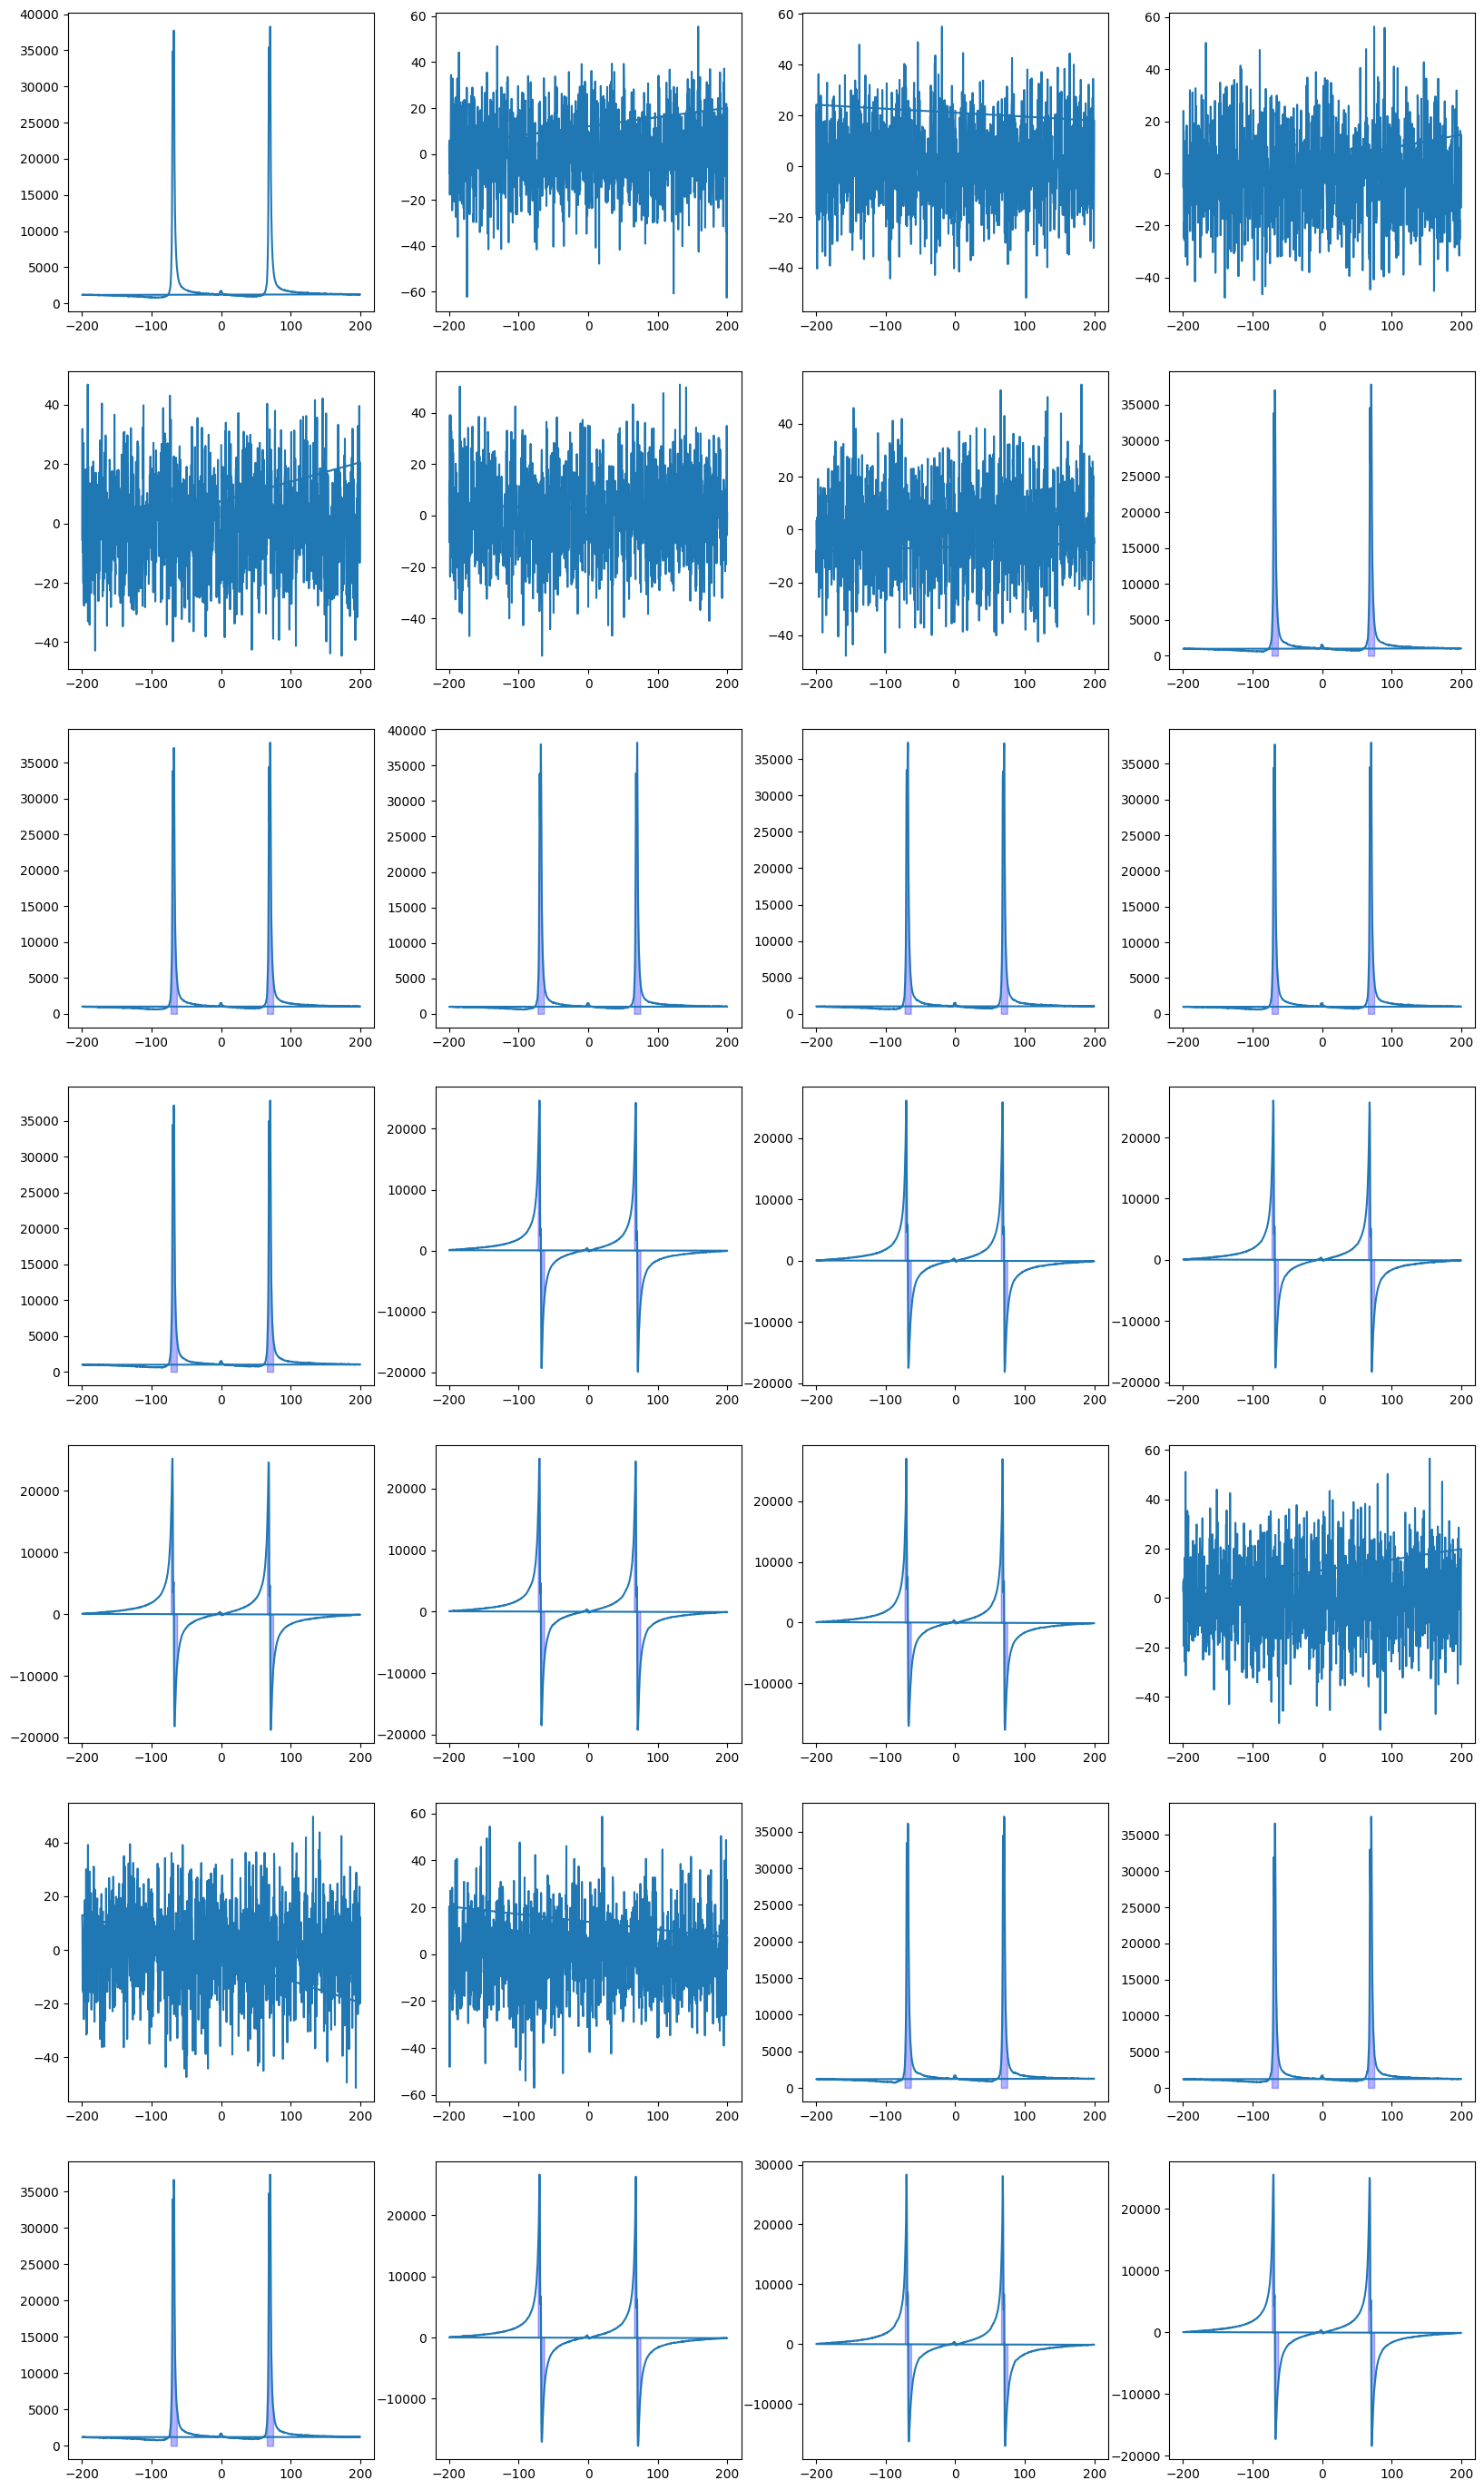

In [9]:
x = np.arange(1, 200, 1)
y = []

ss_original = SpectraSequence(r'test', 'H', order, apply_mask=True)
initial_areas = np.array(ss_original.calculate_areas(peaks))

for iter in x:
    ss = SpectraSequence(r'test', 'H', order, apply_mask=True)
    ss.correct_baselines(iter)
    adjusted_areas = np.array(ss.calculate_areas(peaks))
    relative_difference = np.where(
        initial_areas != 0,
        abs((adjusted_areas - initial_areas) / initial_areas) * 100,
        np.nan
    )
    max_relative_difference = np.nanmax(relative_difference)
    y.append(max_relative_difference)

plt.plot(x, np.array(y))
plt.xlabel('Iterations')
plt.ylabel('Max Relative Difference (%)')
plt.grid()
plt.title('Max Relative Difference vs Iterations')
plt.show()

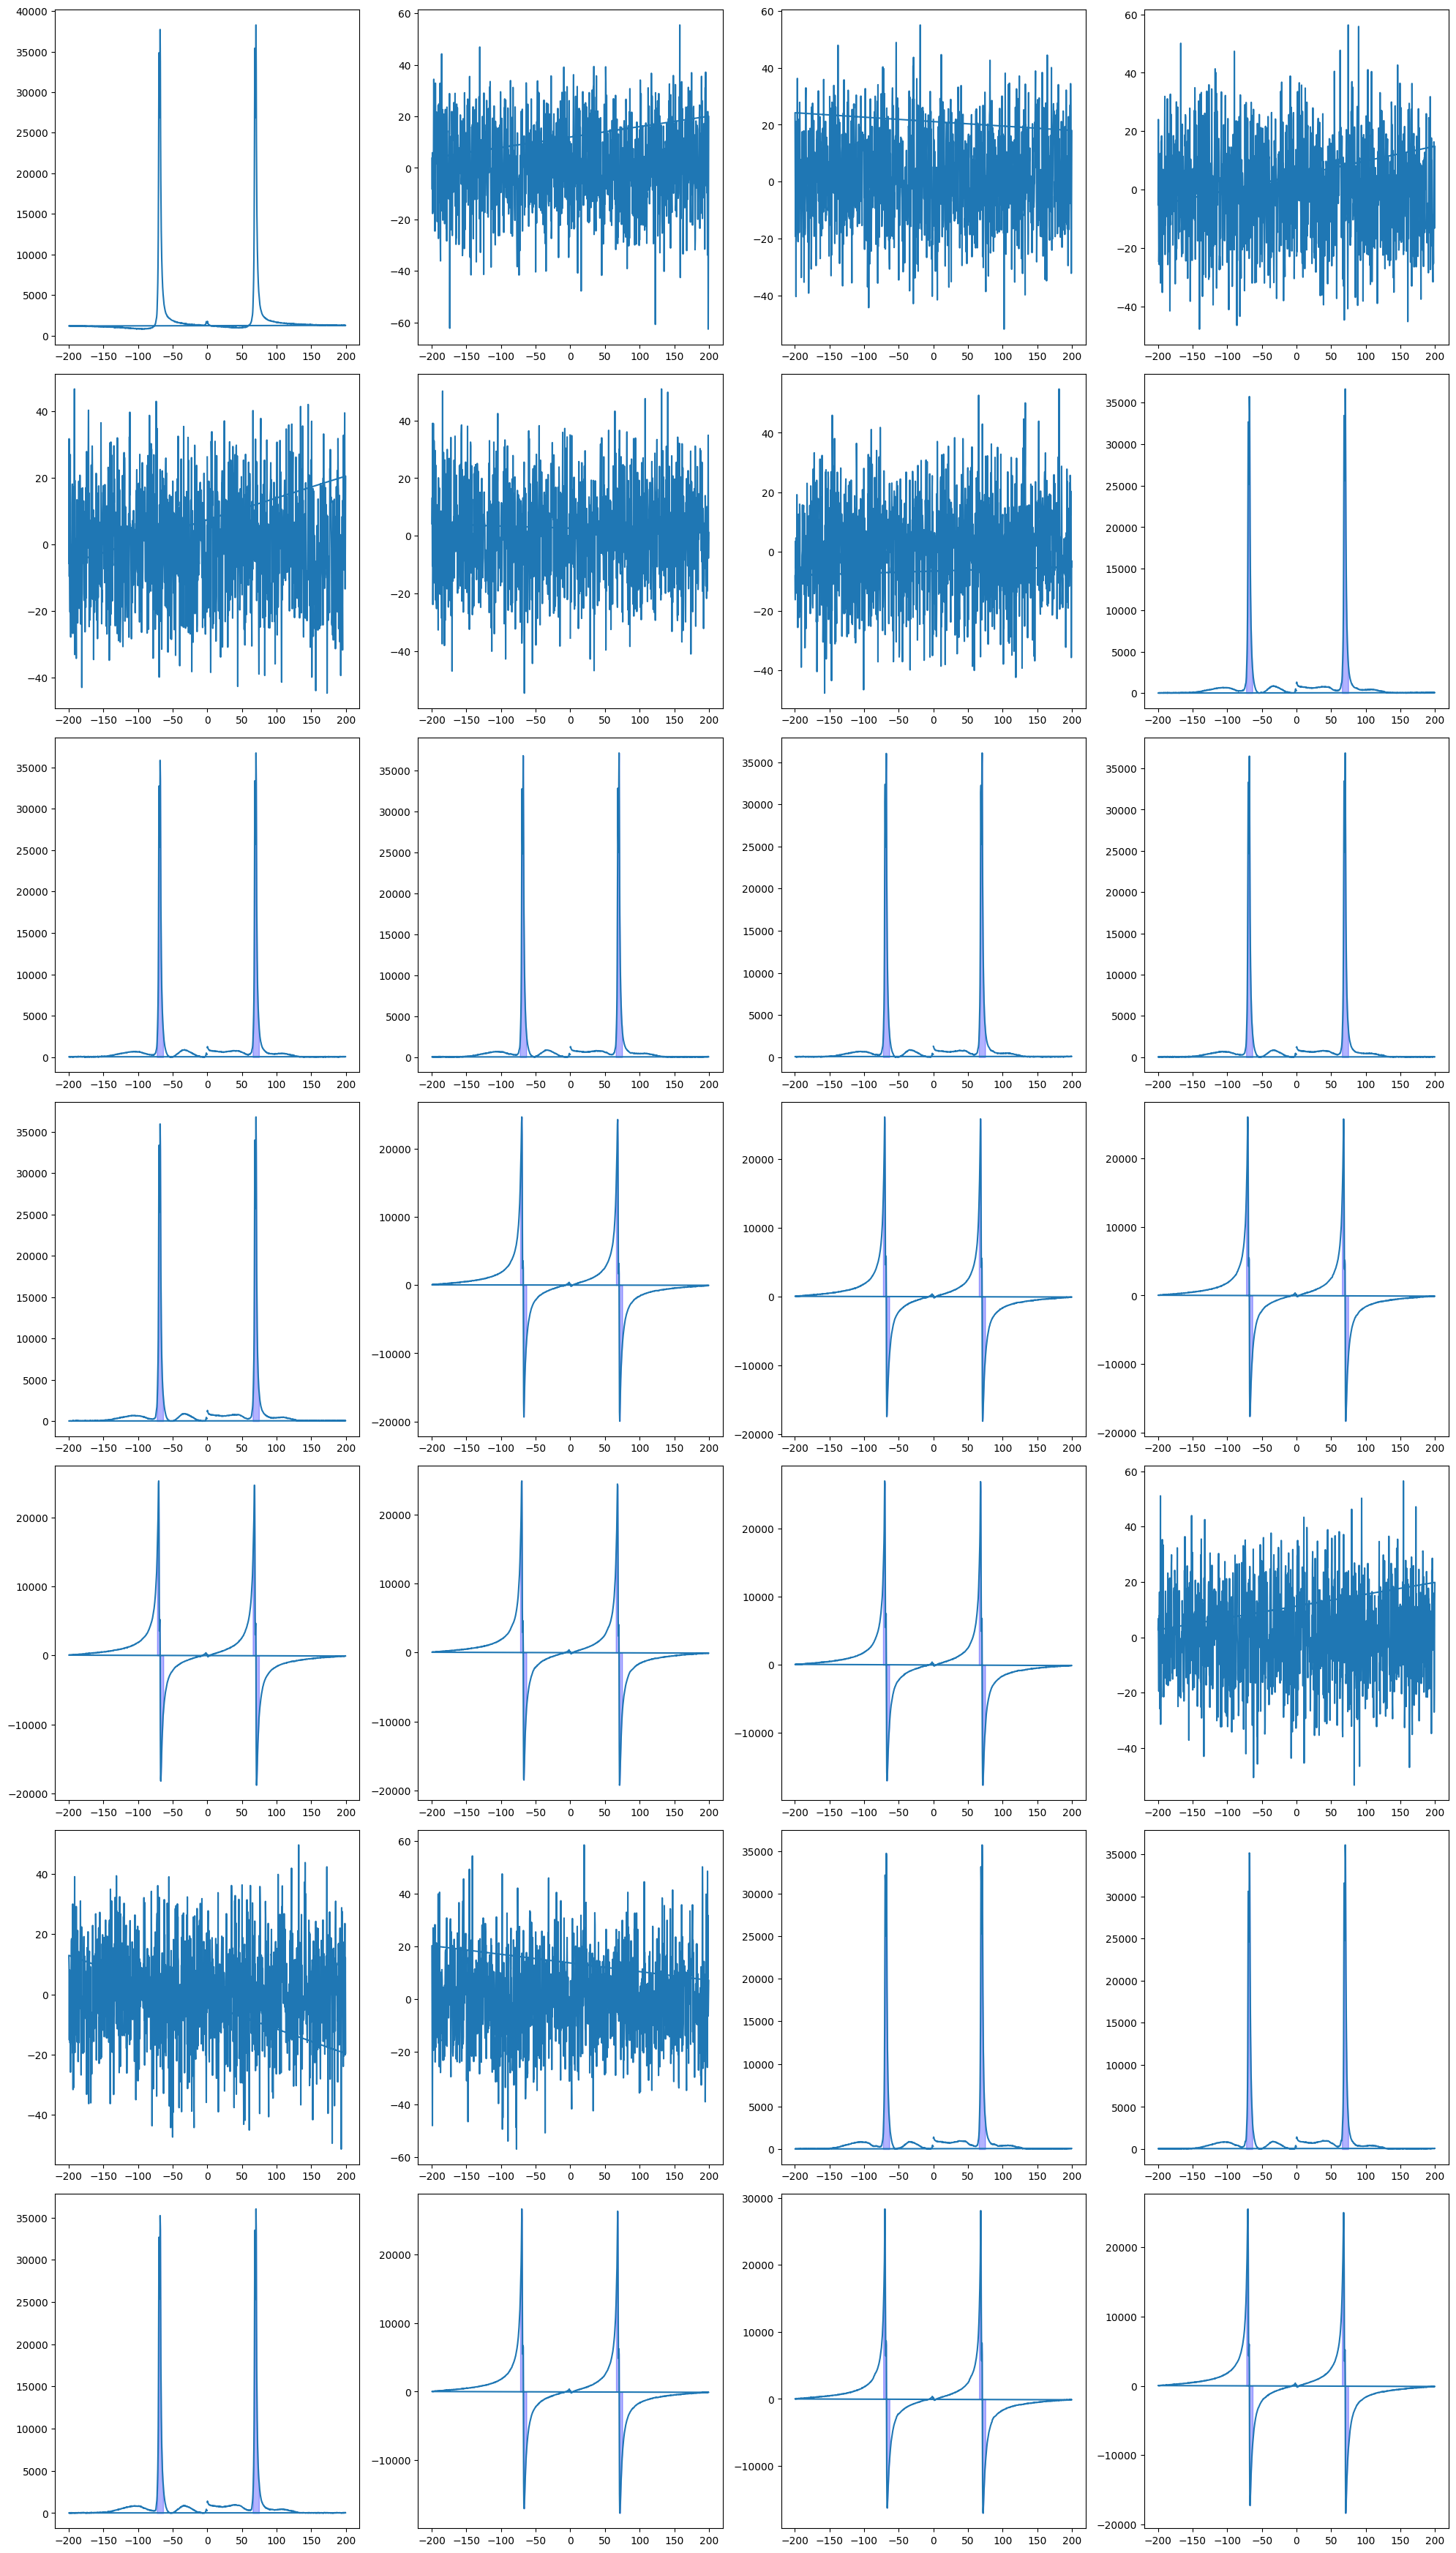

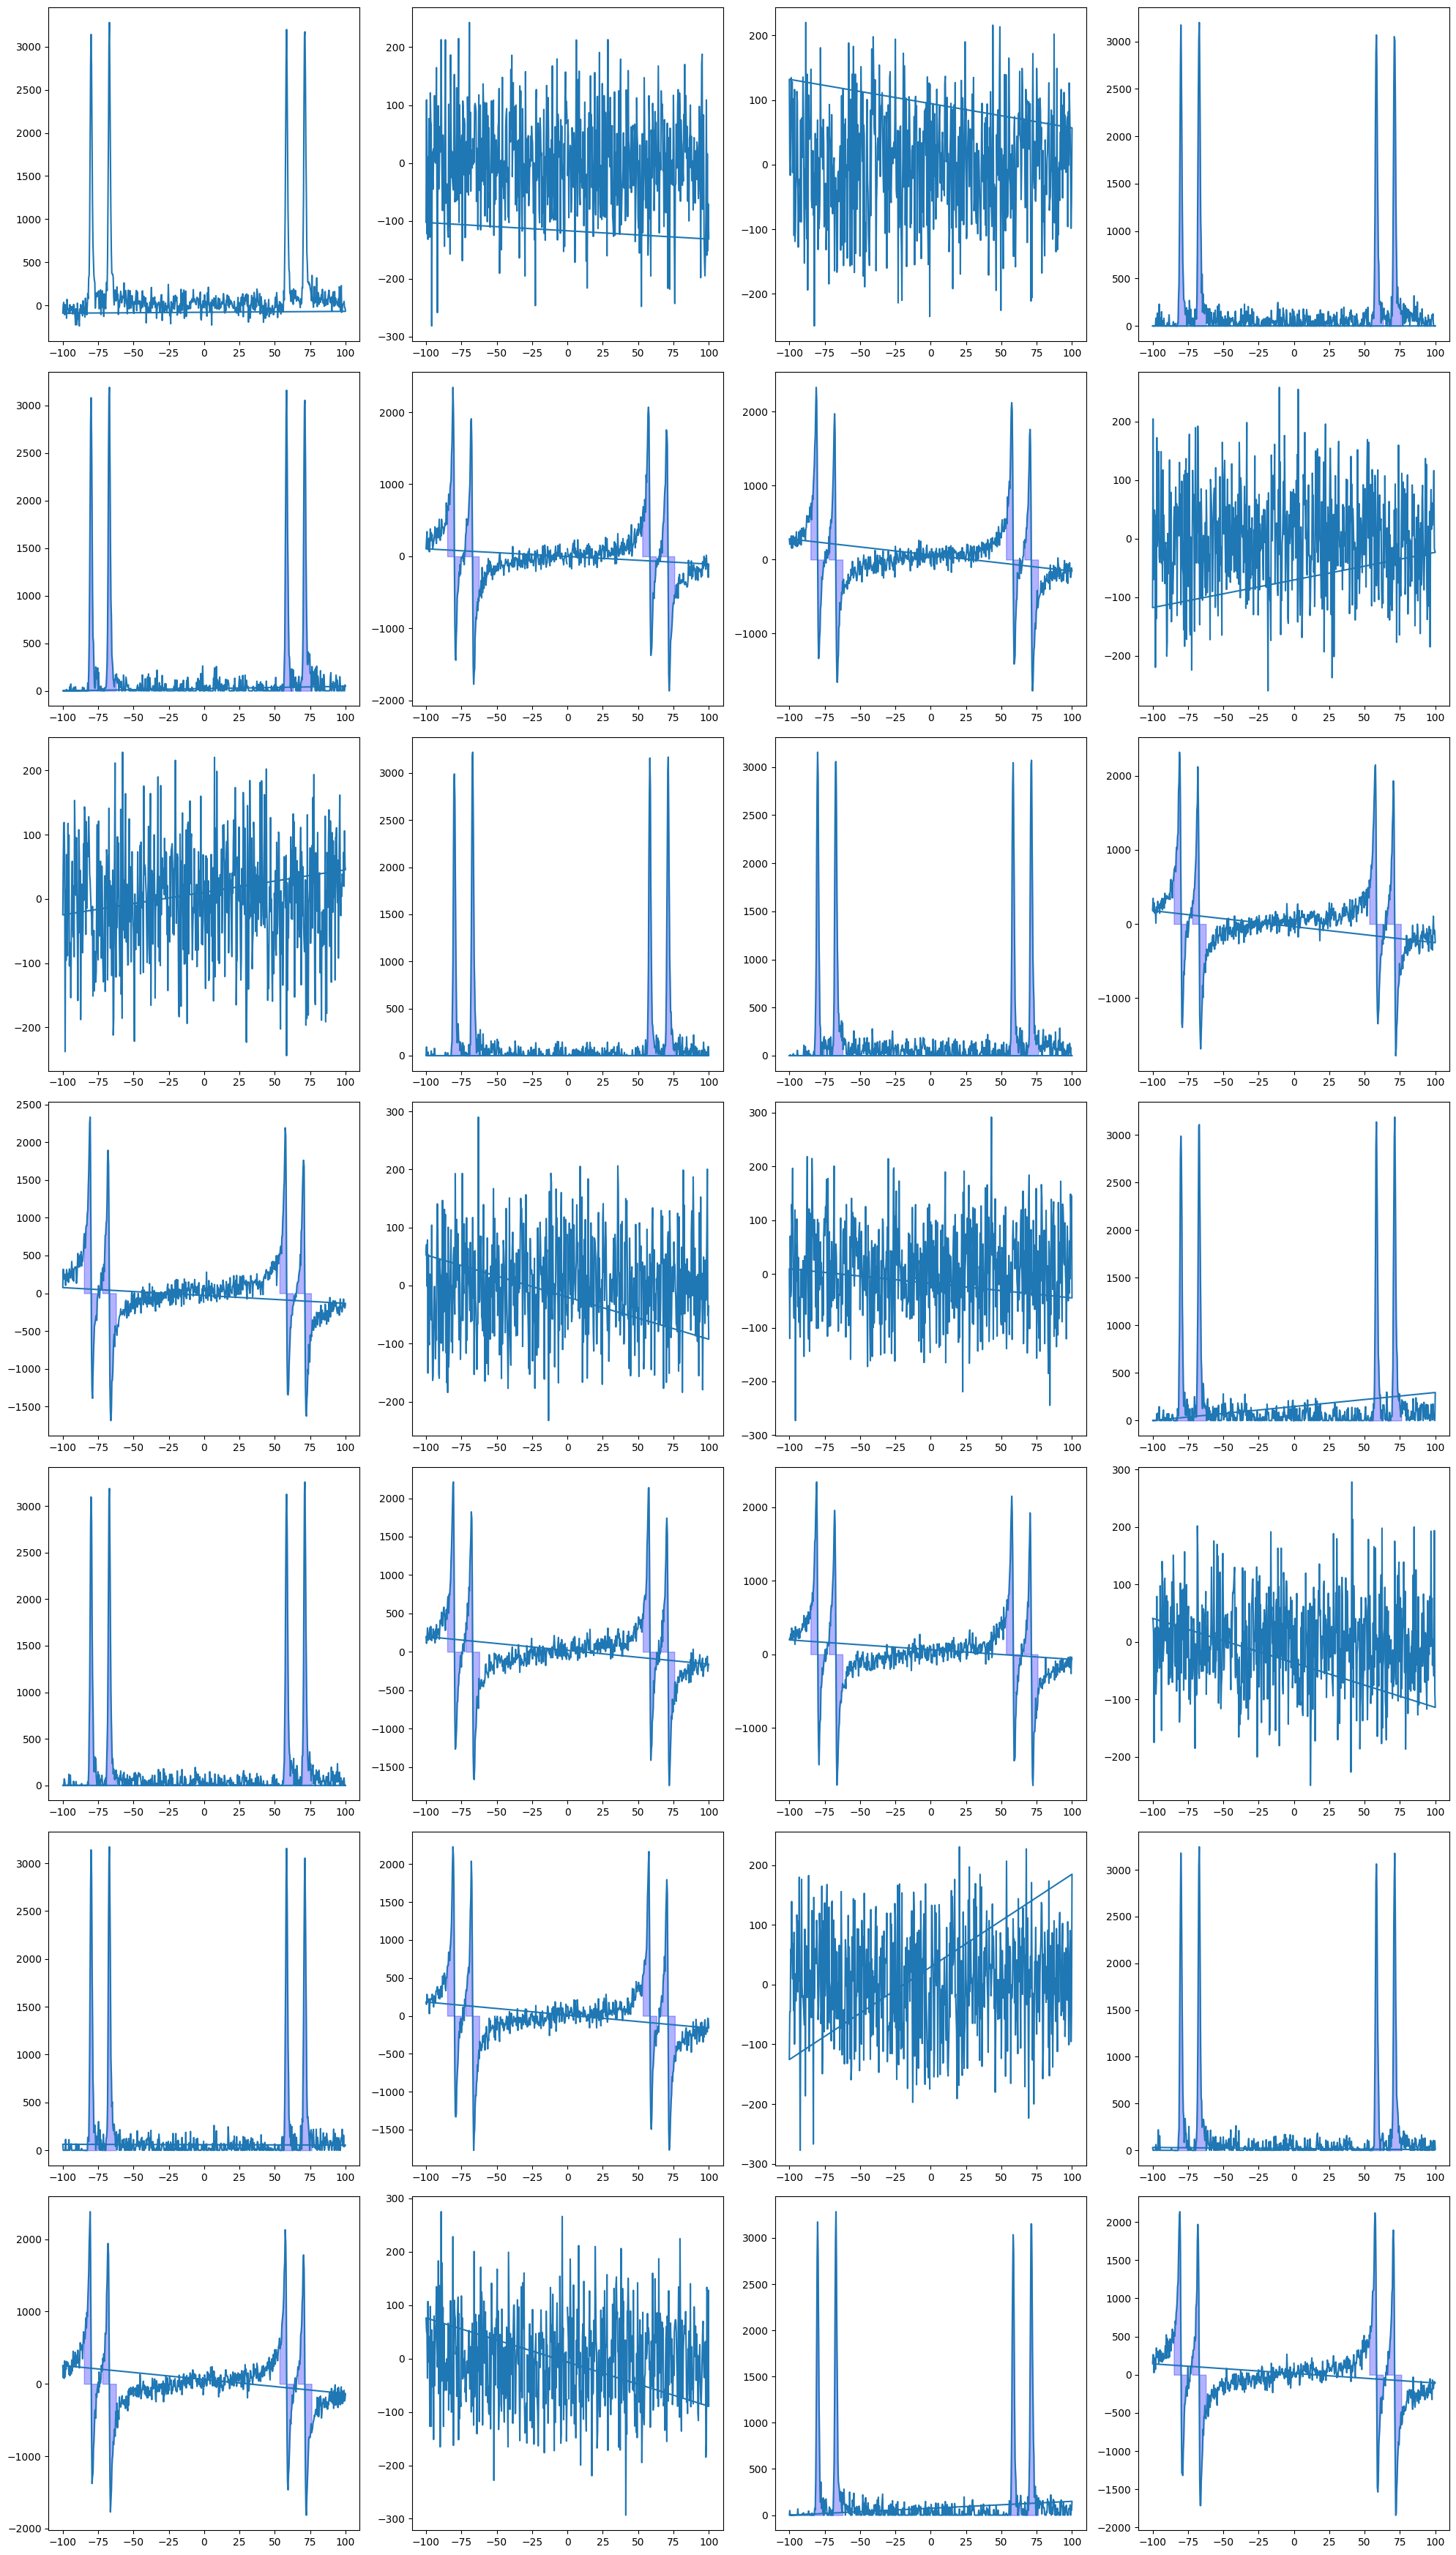

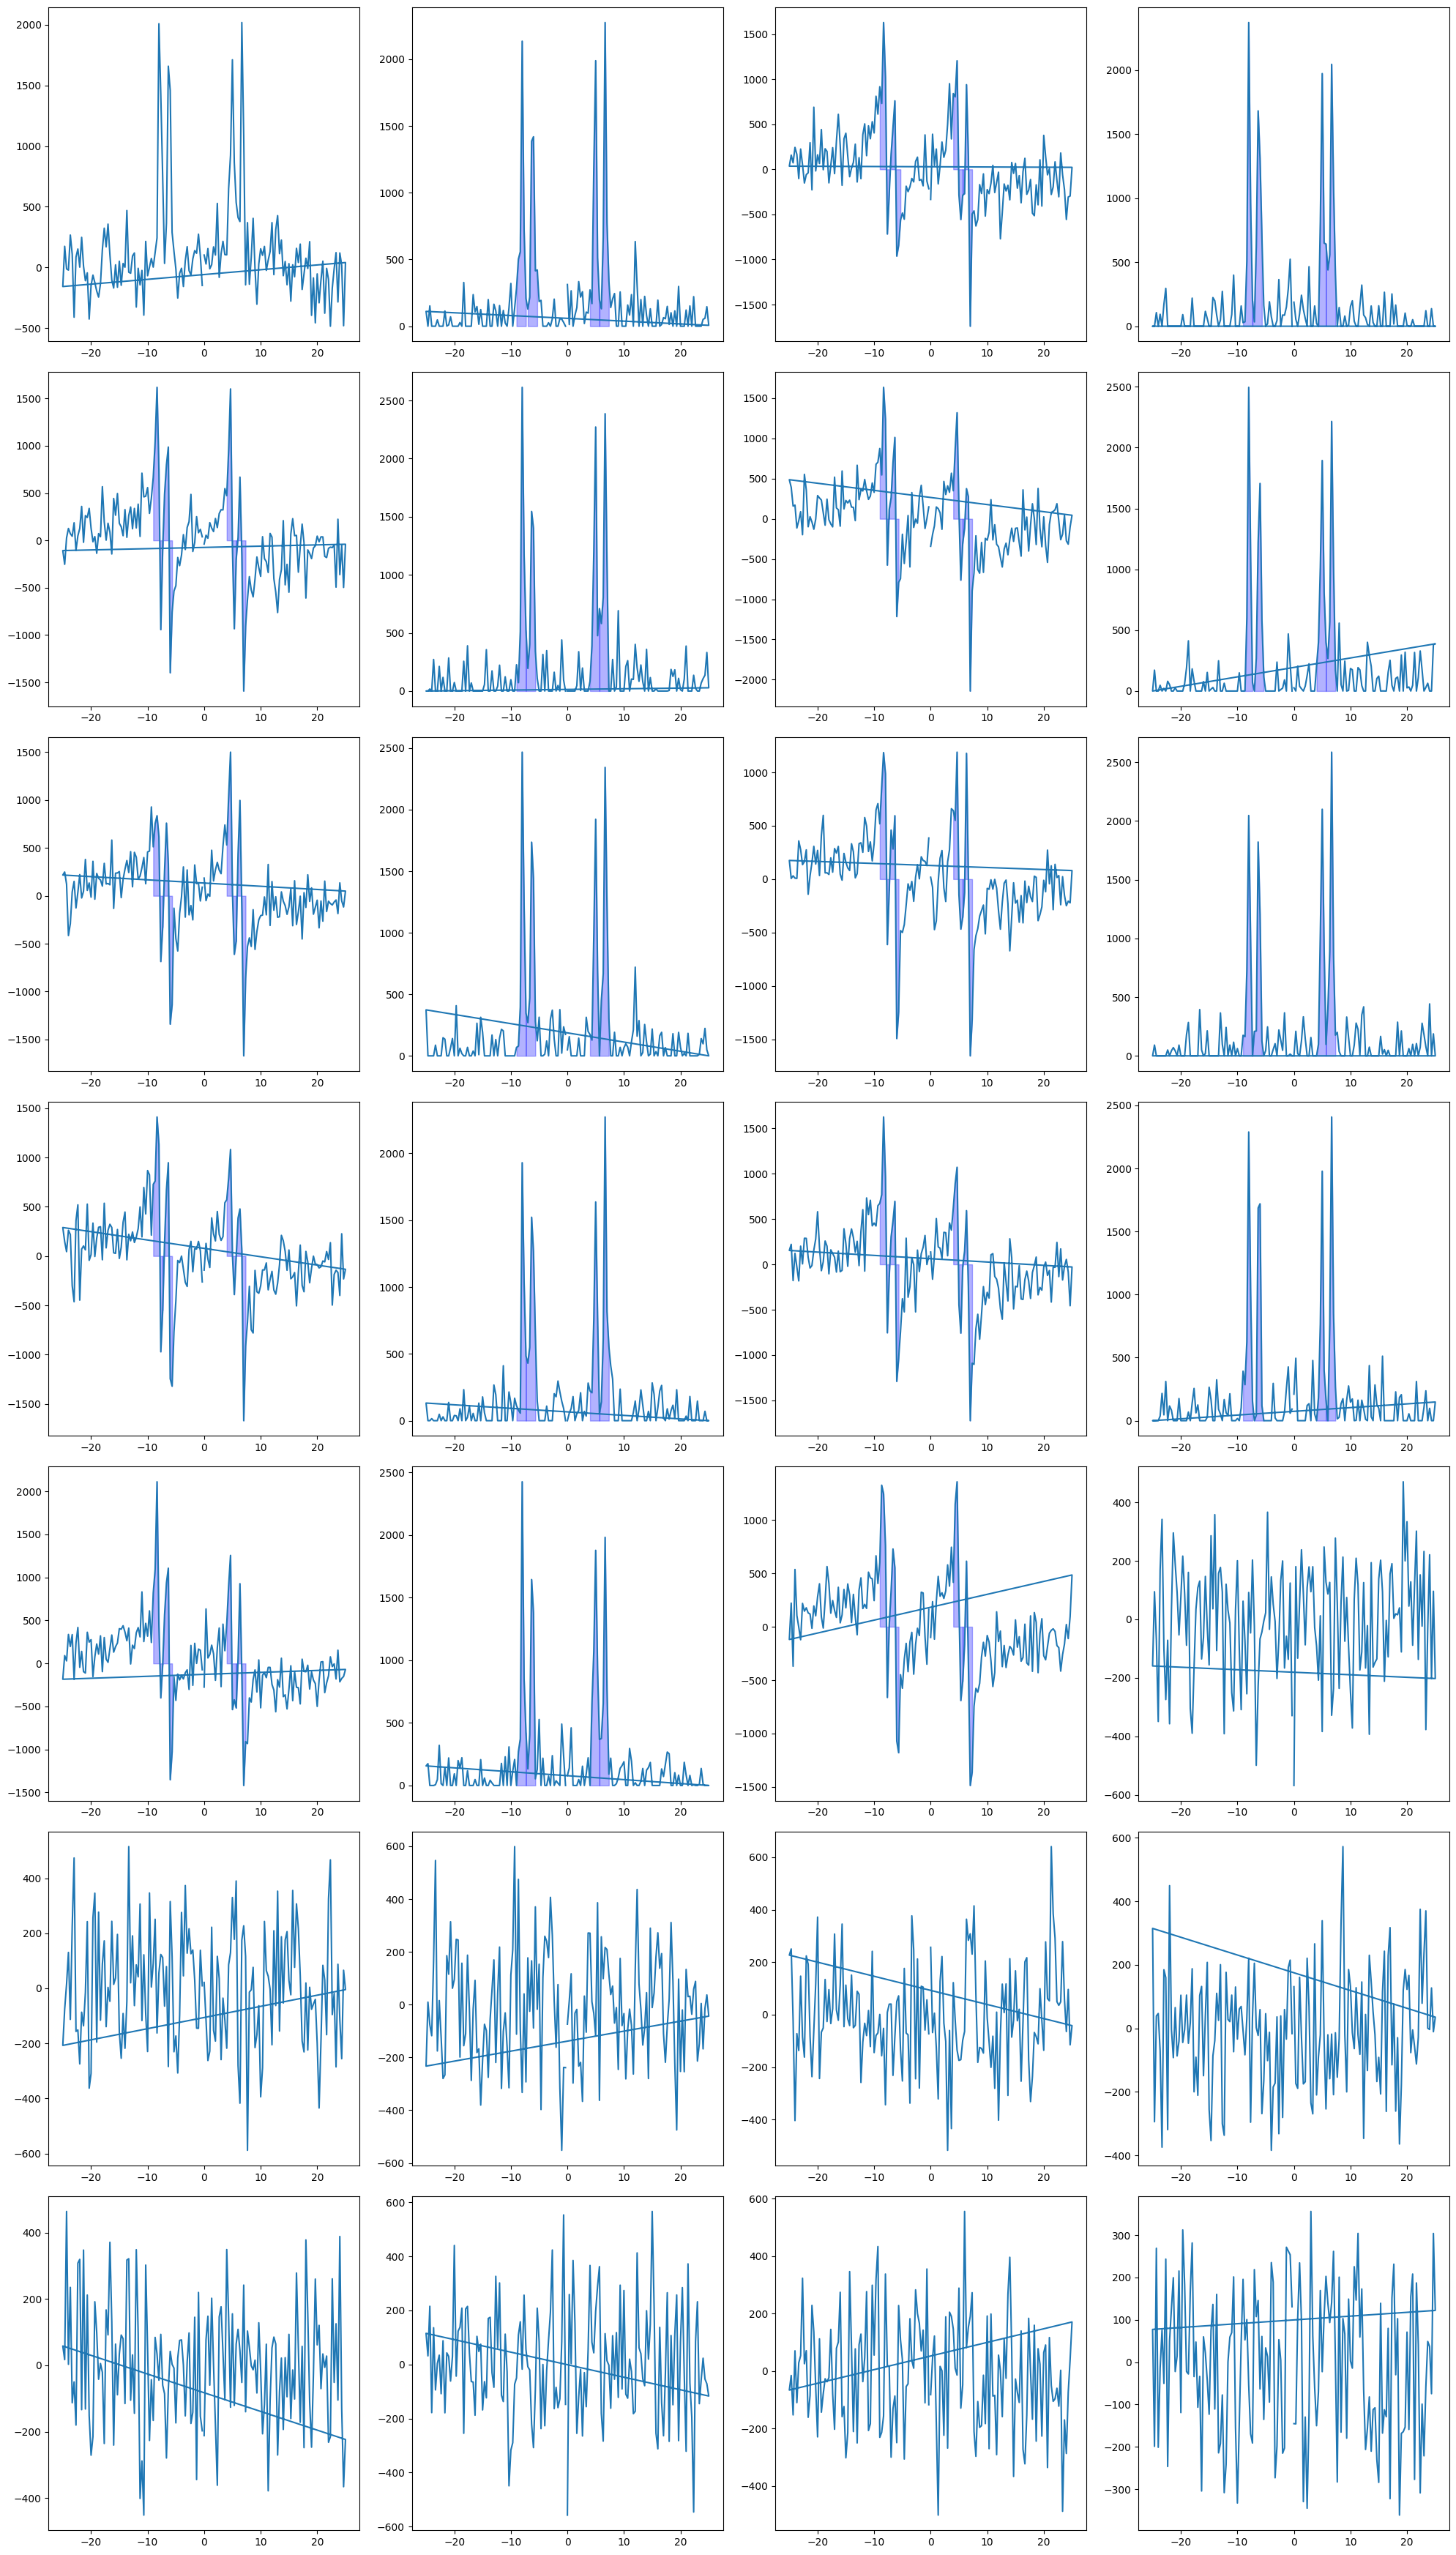

[[array([[0., 0., 0., 0.],
         [0., 0., 0., 0.]]),
  array([[0., 0., 0., 0.],
         [0., 0., 0., 0.]]),
  array([[0., 0., 0., 0.],
         [0., 0., 0., 0.]]),
  array([[0., 0., 0., 0.],
         [0., 0., 0., 0.]]),
  array([[0., 0., 0., 0.],
         [0., 0., 0., 0.]]),
  array([[0., 0., 0., 0.],
         [0., 0., 0., 0.]]),
  array([[0., 0., 0., 0.],
         [0., 0., 0., 0.]]),
  array([[67705.11951696, 67705.11951696, 66439.15115929, 66439.15115929],
         [    0.        ,     0.        ,     0.        ,     0.        ]]),
  array([[67751.07576917, 67751.07576917, 66479.41766269, 66479.41766269],
         [    0.        ,     0.        ,     0.        ,     0.        ]]),
  array([[67822.10637838, 67822.10637838, 66740.4891661 , 66740.4891661 ],
         [    0.        ,     0.        ,     0.        ,     0.        ]]),
  array([[68023.01255109, 68023.01255109, 66664.37128797, 66664.37128797],
         [    0.        ,     0.        ,     0.        ,     0.        ]]),


In [10]:
ss.calculate_areas(peaks)

In [ ]:
from scipy import signal

def proper_phases(data, window):
    spectrum_unpr = np.fft.fft(window * data[0])
    spectrum, phases = ng.proc_autophase.autops(spectrum_unpr, 'acme', return_phases=True)
    return phases

def noize_spectra_idx(data):
    max_vals = []
    for i in range(len(data)):
        spectrum_unpr = np.fft.fft(data[i])
        maxima = max(np.real(spectrum_unpr))
        max_vals.append(maxima)
    threshold = np.mean(maxima) / 100
    indices = [i for i, value in enumerate(max_vals) if value < threshold]
    return indices



tn = 'C' # Название исследуемого ядра

dic, data = ng.varian.read(r'test//C')
df = pd.read_csv('test//dict.csv')
filtered_df = df[df['nucleus'] == 'C']
at = float(dic['procpar']['at']['values'][0])
peak_width = filtered_df['peak_width'].values[0]
center = filtered_df['center'].values[0]
region = filtered_df['borders'].values[0]

window = 1
phases = proper_phases(data, window)
id_idx = noize_spectra_idx(data)
n = len(data[0])
time = np.linspace(0, at, n)
dt = at / n

frequencies = np.fft.fftfreq(n, d=dt)
dnu = frequencies[1] - frequencies[0]
peak_idx_width = int(peak_width / dnu)
mask = (frequencies >= center-region) & (frequencies <= center+region)
frequencies = frequencies[mask]

integrated_areas = []
fig, axs = plt.subplots(6, 4, figsize=(30, 50))
axs = axs.flatten()
spectras = []
peaks = []

for idx in range(len(data)):
    if idx not in id_idx and idx != 0:
        spectrum = np.fft.fft(window * (data[idx]))[mask]
        ph_corrected_spectrum = np.real(spectrum * np.exp(1j * 2 * np.pi / 360 * (phases[0])))
        normalized_spectrum = ph_corrected_spectrum / max(ph_corrected_spectrum)
        bl = baseline(ph_corrected_spectrum, 3)
        corrected_spectrum = ph_corrected_spectrum - bl
        loc_peaks = ng.analysis.peakpick.pick(normalized_spectrum, 0.3, -0.3, table=True)
        iter = 1
        area_indices = []
        for peak in loc_peaks:
            left = int(peak[0] - peak_idx_width)
            right = int(peak[0] + peak_idx_width)
            # area = simps(np.real(ph_corrected_spectrum[left:right]), frequencies[left:right])
            # integrated_areas.append([{'index':idx + 1}, {'integral_num': iter}, {'area':area}])
            iter += 1
        peaks.append(loc_peaks)
        spectras.append(corrected_spectrum)

for idx in range(len(spectras)):
    axs[idx].plot(frequencies, spectras[idx])
    for i in range(len(peaks[idx])):
        s = int(peaks[idx][i][0] + peak_idx_width)
        p = int(peaks[idx][i][0] - peak_idx_width)
        # axs[idx].axvline(x=frequencies[s], color='orange', linestyle='--')
        # axs[idx].axvline(x=frequencies[p], color='blue', linestyle='--')
plt.show()

Optimization terminated successfully.
         Current function value: 1062.591951
         Iterations: 96
         Function evaluations: 182


IndexError: index 24 is out of bounds for axis 0 with size 24